In [1]:
import sys
import numpy as np
import torch 
# still do preprocessing in scipy
import scipy.sparse as sp
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from importlib import reload
import pandas as pd 
import seaborn as sns

# import nn PCA model from nuclear-norm-pca
sys.path.append('/gpfs/commons/home/kisaev/Leaflet/src/nuclear-norm-pca')
import kuckle_model
from kuckle_model import *

### Settings and Load data

In [2]:
leaflet_repo = '/gpfs/commons/home/kisaev/Leaflet/src/beta-binomial-mix/' #need to move load_cluster_data function to general module utils 
sys.path.append(leaflet_repo)
import load_cluster_data
from betabinomo_mix_singlecells import *

In [3]:
torch.manual_seed(42)

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

cpu


In [4]:
input_files_folder = '/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/'

cell_types = ['Brain_Non-Myeloid_brain_pericyte','Brain_Non-Myeloid_oligodendrocyte_precursor_cell','Brain_Non-Myeloid_endothelial_cell','Brain_Non-Myeloid_oligodendrocyte',
 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage',
 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']

# convert data to Leaflet required input formats 
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data.load_cluster_data(
    input_folder = input_files_folder, max_intron_count=5000, celltypes=cell_types, has_genes="yes") 

# add cluster to final_data 
final_data = final_data.merge(junction_ids_conversion, on=["junction_id_index"], how="left")

# get indices (maybe don't need this actually)
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))

Reading in data from folder ...
/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/TabulaMurisBrain/MLCB_Brain_true/FULL/


Finished reading in data from folder ...
Looking at only specific cell types ...['Brain_Non-Myeloid_brain_pericyte', 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell', 'Brain_Non-Myeloid_endothelial_cell', 'Brain_Non-Myeloid_oligodendrocyte', 'Brain_Non-Myeloid_neuron', 'Brain_Myeloid_macrophage', 'Brain_Myeloid_microglial_cell', 'Brain_Non-Myeloid_astrocyte']
['Brain_Non-Myeloid_brain_pericyte'
 'Brain_Non-Myeloid_oligodendrocyte_precursor_cell'
 'Brain_Non-Myeloid_endothelial_cell' 'Brain_Non-Myeloid_oligodendrocyte'
 'Brain_Non-Myeloid_neuron' 'Brain_Myeloid_macrophage'
 'Brain_Myeloid_microglial_cell' 'Brain_Non-Myeloid_astrocyte']
7816
16190
The maximum junction count was initially:  150346
80
The maximum junction count is now:  4982
                                             cell_id  Cluster  Cluster_Counts  \
0  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...        4              21   
1  A14-MAA000581-3_10_M-1-1_Brain_Non-Myeloid_bra...        4              21   
2  A14-

In [5]:
## simple PCA with imputation of missing values 

# make matrix of junctions by cells and fill with juncratio values 
mat = np.zeros((len(final_data.cell_id_index.unique()), len(final_data.junction_id_index.unique())))
mat[final_data.cell_id_index, final_data.junction_id_index] = final_data.juncratio
mat[~(final_data.cell_id_index), ~(final_data.junction_id_index)] = np.nan

# imput nan values using mean of each row (does this make sense?)
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp.fit(mat)
mat_imputed = imp.transform(mat)

# run PCA on mat_imputed 
pca = PCA(n_components=10)
pca.fit(mat_imputed)
print(pca.explained_variance_ratio_)

pcs = pca.transform(mat_imputed)
pcs_df = pd.DataFrame(pcs, columns=["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8", "PC9", "PC10"])
cell_types_pcs = cell_ids_conversion["cell_type"]

[0.0672032  0.01925902 0.01560112 0.01093991 0.00515439 0.00346535
 0.00298153 0.00264373 0.00224763 0.00207942]


Text(0.5, 1.0, 'PCA of Junction Usage Ratios (imputed matrix)')

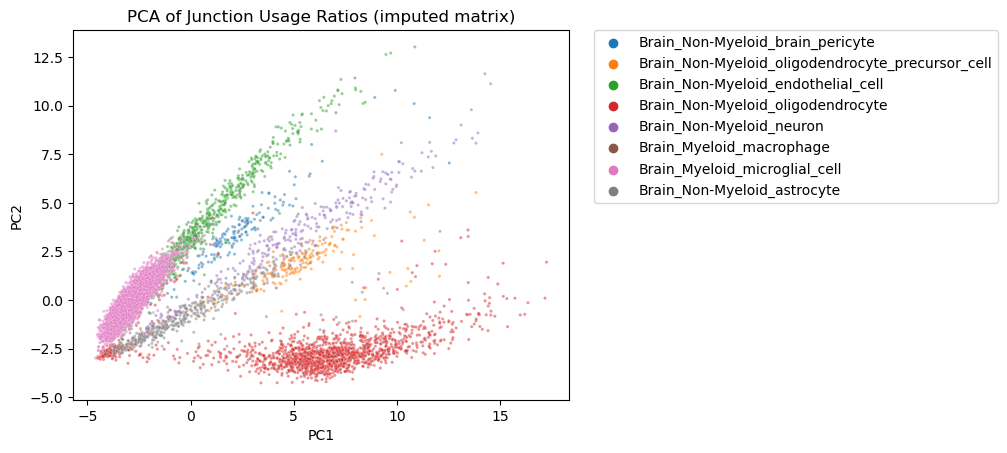

In [6]:
# plot first two PCs
sns.scatterplot(data=pcs_df, x="PC1", y="PC2", hue=cell_types_pcs.values, s=5, alpha=0.5)
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("PCA of Junction Usage Ratios (imputed matrix)")

In [7]:
# let's use PCs to get silhouette scores via cell type labels 
# import silhouette_score
from sklearn.metrics import silhouette_score
silhouette_score(pcs, cell_ids_conversion.cell_type.values) # likely inflated by the imputation which may just reflect global gene expression trends?

0.28730601058287497

In [8]:
# get Davies-Bouldin Index
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(pcs, cell_ids_conversion.cell_type.values) # lower is better

1.5224519401840817

### Filter junctions and set up Y and W (weight matrix of inverse variances of the PSI values)

also printing original indices of junctions we are keeping


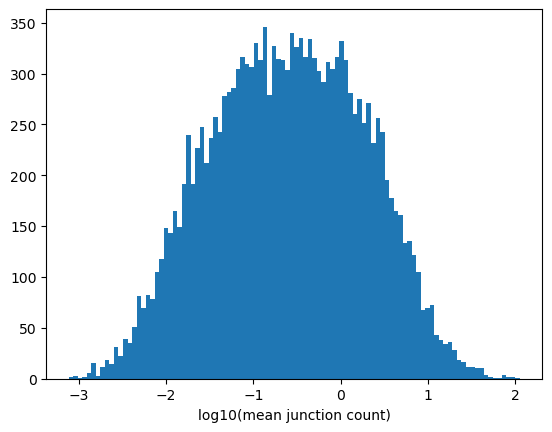

In [8]:
junc_counts_sub, cluster_counts_sub, junc_keep = filter_junctions(
    junc_counts, cluster_counts, plot = True)

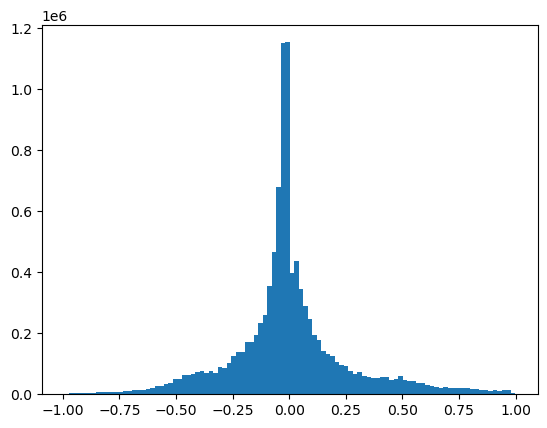

In [9]:
# set up data for nuc norm PCA
Y_data, w = make_Y(
    junc_counts_sub, cluster_counts_sub, float_type)

# np.mean(Y_data * Y_data) * psi.shape[0] * psi.shape[1]
Y = torch.tensor(Y_data, **float_type)
W = torch.tensor(w.data, **float_type)

_ = plt.hist(Y_data, 100) # centered so the distribution peaks at 0 and is in [-1,1]

### Split into training and test data 

In [10]:
Y_train, W_train, indices_train, Y_test, W_test, indices_test = train_test(
    Y_data, w, float_type)

### Run nuclear norm PCA constraint search 

In [11]:
rmseTol = 5e-5
its=10

rs, testErrors, trainErrors, nuc_norms, final_svd, step_times = constraint_search(
    indices_train, 
    Y_train, 
    W_train, 
    size = junc_counts_sub.shape,
    indices_test = indices_test, 
    Y_test = Y_test, 
    W_test = W_test, 
    rmseTol = rmseTol, 
    end = "\n",
    inner_verbose = True,
    power_iteration_controller = (30,1.),
    its = its,  
    **float_type)

CV	Bound	RMSE	TestRMSE
It	RMSE	Step	DeltaRMSE


/gpfs/commons/home/kisaev/Leaflet/src/nuclear-norm-pca/kuckle_model.py:311: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  phi = torch.tensor(phi, dtype = float_type["dtype"], device = "cpu") # this is always on CPU


CV	1e+03	0.227	0.23
It	RMSE	Step	DeltaRMSE
CV	1.5e+03	0.223	0.2282717
It	RMSE	Step	DeltaRMSE
CV	2.25e+03	0.219	0.227526
It	RMSE	Step	DeltaRMSE
CV	3.38e+03	0.216	0.226865
It	RMSE	Step	DeltaRMSE
CV	5.06e+03	0.213	0.2262793
It	RMSE	Step	DeltaRMSE
CV	7.59e+03	0.21	0.22502701
It	RMSE	Step	DeltaRMSE
CV	1.14e+04	0.207	0.2252972
It	RMSE	Step	DeltaRMSE
CV	1.71e+04	0.204	0.2242947
It	RMSE	Step	DeltaRMSE
CV	2.56e+04	0.202	0.2242625
It	RMSE	Step	DeltaRMSE
CV	3.84e+04	0.199	0.22420815
It	RMSE	Step	DeltaRMSE
CV	5.77e+04	0.196	0.22402588
It	RMSE	Step	DeltaRMSE
CV	8.65e+04	0.194	0.22424946
It	RMSE	Step	DeltaRMSE
CV	1.3e+05	0.192	0.224025464
It	RMSE	Step	DeltaRMSE
CV	1.95e+05	0.189	0.22402192
It	RMSE	Step	DeltaRMSE


### Plot results 

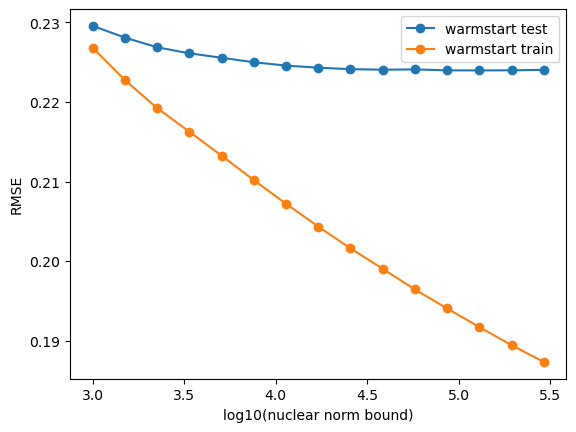

In [12]:
plt.plot(np.log10(rs), testErrors,"-o", label = "warmstart test") #rs = list of nuclear norm bounds used 
plt.plot(np.log10(rs), trainErrors, "-o", label = "warmstart train")
plt.ylabel("RMSE")
plt.xlabel("log10(nuclear norm bound)")
plt.legend()

tensor(5313.8726)

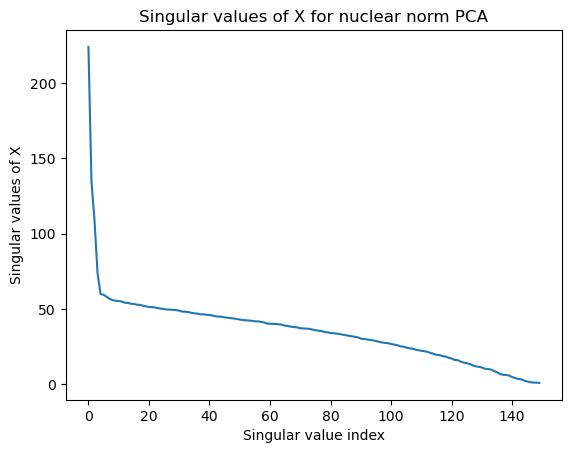

In [13]:
plt.plot(final_svd.S)
plt.ylabel("Singular values of X") 
plt.xlabel("Singular value index")
# add title
plt.title("Singular values of X for nuclear norm PCA")
final_svd.S.sum()

In [14]:
nuc_norms # nuc_norms.append(final_svd.S.sum().item())

[499.87530517578125,
 824.022216796875,
 1142.9268798828125,
 1439.5919189453125,
 1779.808349609375,
 2140.45947265625,
 2504.10498046875,
 2880.915283203125,
 3251.433349609375,
 3601.06298828125,
 3983.183837890625,
 4319.83251953125,
 4659.10009765625,
 5007.04931640625,
 5313.87255859375]

Text(0, 0.5, 'log10(Nuc norm obtained)')

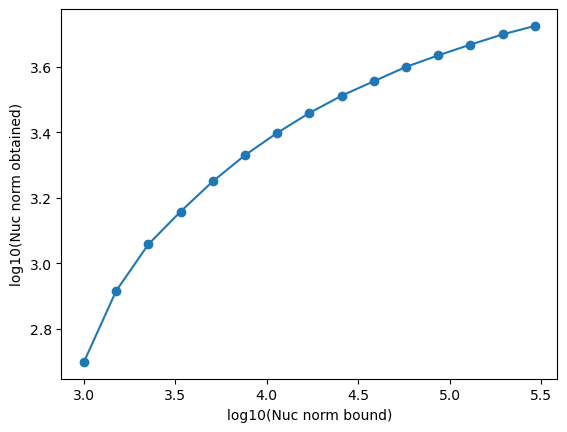

In [15]:
# solution is on the boundary up to about ~1e4, then is inside. 
plt.plot(np.log10(rs), np.log10(nuc_norms), "-o", label = "warmstart")
plt.xlabel("log10(Nuc norm bound)")
plt.ylabel("log10(Nuc norm obtained)")

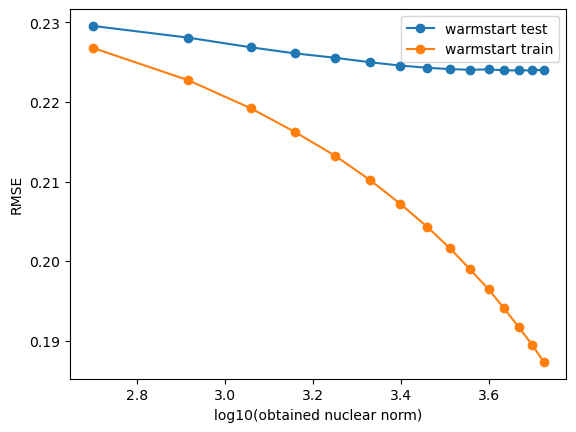

In [16]:
plt.plot(np.log10(nuc_norms), testErrors,"-o", label = "warmstart test")
plt.plot(np.log10(nuc_norms), trainErrors, "-o", label = "warmstart train")
plt.ylabel("RMSE")
plt.xlabel("log10(obtained nuclear norm)")
plt.legend()

In [17]:
r_best = rs[np.argmin(testErrors)]
r_best

129746.337890625

In [18]:
Y,W,indices = to_torch(Y_data, w, **float_type)

### Re-run constraint_search with our best r_best

In [19]:
rs, _, trainErrors_all, nuc_norms_all, final_svd_all, step_times = constraint_search(
    indices, 
    Y, 
    W, 
    size = junc_counts_sub.shape,
    rmseTol = rmseTol, 
    its = its,  
    max_r = r_best, 
    end = "\n",
    **float_type)


CV	Bound	RMSE	TestRMSE
CV	1e+03	0.227	nan
CV	1.5e+03	0.224	nan
CV	2.25e+03	0.22	nan
CV	3.38e+03	0.218	nan
CV	5.06e+03	0.215	nan
CV	7.59e+03	0.212	nan
CV	1.14e+04	0.21	nan
CV	1.71e+04	0.207	nan
CV	2.56e+04	0.205	nan
CV	3.84e+04	0.202	nan
CV	5.77e+04	0.2	nan
CV	8.65e+04	0.198	nan
CV	1.3e+05	0.196	nan


In [20]:
r_best

129746.337890625

### Settings and Load data

Text(0.5, 1.0, 'Singular values of X for nuclear norm PCA')

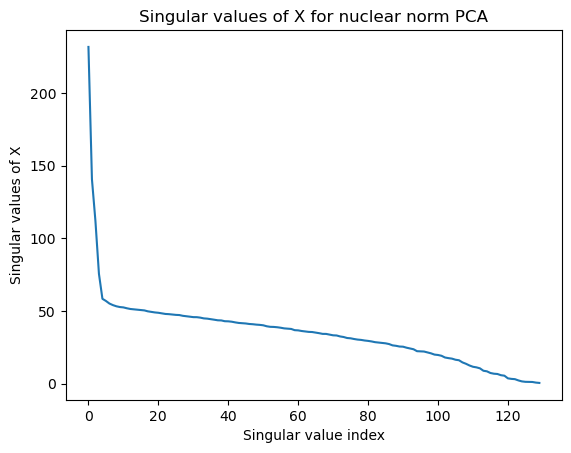

In [21]:
plt.plot(final_svd_all.S) # final_svd = orthonormer(U, V, phi) --> orthonormalization process on the singular vectors (stored in U and V) and singular values (phi) obtained from the nuc_norm_PCA
 # add xlab 
plt.xlabel("Singular value index")
# add ylab
plt.ylabel("Singular values of X")
# add title
plt.title("Singular values of X for nuclear norm PCA")

In [22]:
final_svd_all.U

tensor([[ 9.4029e-03, -1.0001e-03, -1.6567e-02,  ..., -1.5026e-04,
         -1.0967e-03, -9.9003e-05],
        [ 5.0975e-03, -8.9270e-03, -3.5996e-02,  ..., -1.5615e-03,
          3.0574e-03, -1.5888e-02],
        [ 6.9657e-03, -4.8951e-03, -6.4017e-03,  ...,  1.8833e-03,
         -3.1737e-03, -1.3994e-02],
        ...,
        [-2.7629e-03, -1.7775e-03, -1.4707e-03,  ..., -1.0307e-02,
          8.3367e-03,  7.0362e-03],
        [-5.7615e-03, -1.6573e-03,  5.9190e-03,  ..., -9.5466e-03,
         -2.8139e-03,  4.3598e-03],
        [-6.7064e-03, -8.9043e-04, -4.3184e-05,  ..., -9.3243e-03,
          1.0225e-02,  8.1436e-03]])

In [23]:
# convert to df and rename columns to be PCA_1, PCA_2, etc.
PC_df = pd.DataFrame(final_svd_all.U)
PC_df.columns = ["PCA_" + str(i) for i in range(1, PC_df.shape[1] + 1)]
PC_df["cell_type"] = cell_ids_conversion["cell_type"].to_numpy()
PC_df

,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,...,PCA_122,PCA_123,PCA_124,PCA_125,PCA_126,PCA_127,PCA_128,PCA_129,PCA_130,cell_type
0,0.009403,-0.001000,-0.016567,0.001568,-0.021313,-0.026789,-0.015518,0.001526,-0.006151,0.015478,...,0.013022,0.001894,-0.004332,-0.003047,0.012463,0.006219,-0.000150,-0.001097,-0.000099,Brain_Non-Myeloid_brain_pericyte
1,0.005098,-0.008927,-0.035996,0.001011,-0.032415,0.003705,0.009936,0.009774,0.006617,-0.009827,...,0.022645,-0.013306,-0.013623,0.015810,0.009627,0.004004,-0.001561,0.003057,-0.015888,Brain_Non-Myeloid_brain_pericyte
2,0.006966,-0.004895,-0.006402,-0.007531,-0.009044,-0.014269,-0.007951,-0.002508,0.004572,-0.005375,...,0.012175,0.001944,-0.006777,0.005106,0.001976,0.012668,0.001883,-0.003174,-0.013994,Brain_Non-Myeloid_brain_pericyte
3,0.005825,-0.003733,-0.025342,-0.015304,-0.042116,-0.026428,-0.012391,0.007854,0.029279,-0.025217,...,-0.011794,-0.004545,-0.007150,-0.005198,0.008567,-0.001081,0.023664,0.013520,-0.016474,Brain_Non-Myeloid_brain_pericyte
4,0.004527,-0.005313,-0.026976,-0.017800,-0.004603,-0.036102,-0.028588,0.012729,0.014049,-0.020477,...,0.023416,-0.000225,-0.001571,-0.001404,0.003070,0.038773,0.044170,0.037532,0.003013,Brain_Non-Myeloid_brain_pericyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7811,-0.003181,0.000016,-0.003901,-0.004457,0.013147,-0.000295,-0.000893,-0.004892,0.003390,0.002572,...,-0.001292,0.003380,0.003446,0.002149,0.008729,-0.004166,-0.003500,-0.007666,-0.008316,Brain_Non-Myeloid_astrocyte
7812,-0.002817,0.001354,0.001207,-0.004203,0.003765,-0.002918,-0.003447,-0.003043,0.004936,-0.001448,...,0.004372,-0.000934,0.000815,-0.003268,0.001564,-0.004190,0.002576,0.002934,-0.000525,Brain_Non-Myeloid_astrocyte
7813,-0.002763,-0.001778,-0.001471,-0.017823,0.009028,-0.009968,0.001152,-0.003978,-0.001596,0.002659,...,-0.005587,0.009183,0.008588,-0.014530,0.002308,-0.006550,-0.010307,0.008337,0.007036,Brain_Non-Myeloid_astrocyte
7814,-0.005761,-0.001657,0.005919,-0.002071,0.009382,0.000839,0.000180,-0.009865,0.001192,0.009676,...,-0.003528,-0.001934,-0.011659,-0.001526,0.016426,-0.007912,-0.009547,-0.002814,0.004360,Brain_Non-Myeloid_astrocyte


<Axes: xlabel='PCA_1', ylabel='PCA_2'>

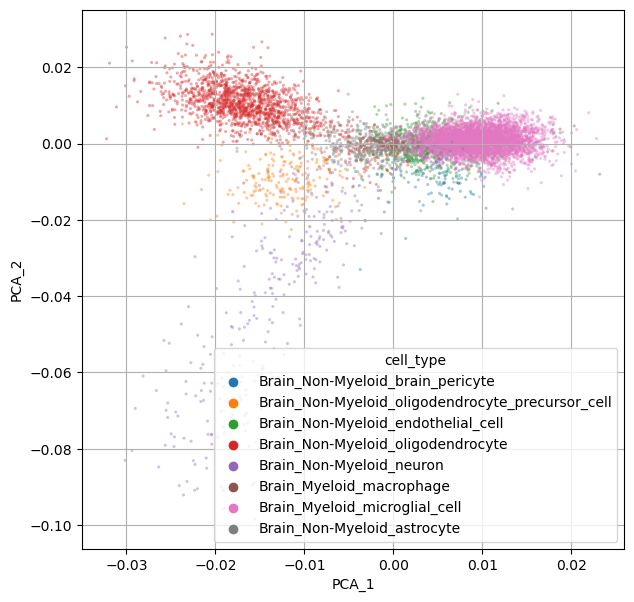

In [24]:
plt.figure(figsize=[7,7])
# add grid to plot
plt.grid()
sns.scatterplot(x = "PCA_1",y = "PCA_2", hue="cell_type", data= PC_df, edgecolor = 'none', alpha = 0.4, s=5)

<Axes: xlabel='PCA_1', ylabel='PCA_3'>

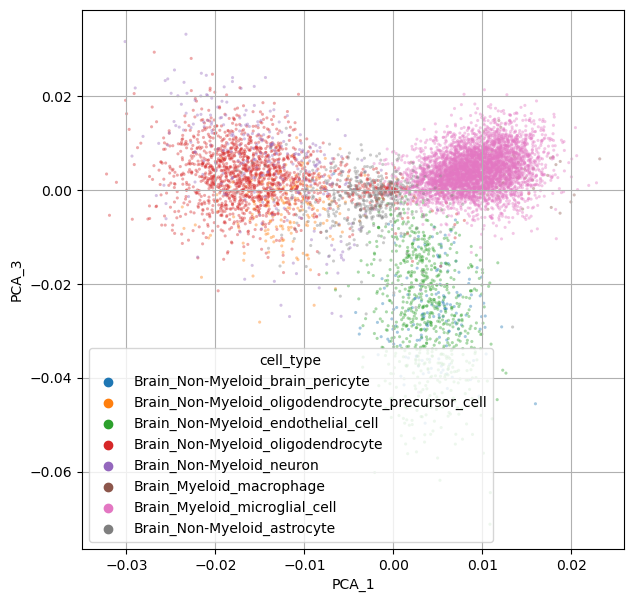

In [25]:
plt.figure(figsize=[7,7])
# add grid to plot
plt.grid()
sns.scatterplot(x = "PCA_1",y = "PCA_3", hue="cell_type", data= PC_df, edgecolor = 'none', alpha = 0.4, s=5)

Text(0.5, 0, 'Singular value index')

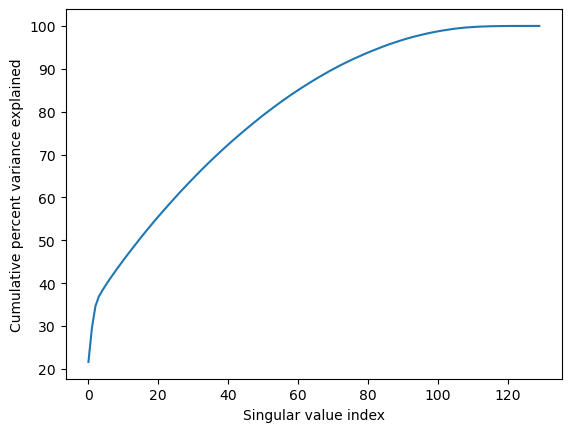

In [26]:
pve = final_svd_all.S**2
pve /= pve.sum()
pve = pve.cumsum(0) * 100
plt.plot(pve)
plt.ylabel("Cumulative percent variance explained")
# add xlabel
plt.xlabel("Singular value index")

In [27]:
final_svd_all.U

tensor([[ 9.4029e-03, -1.0001e-03, -1.6567e-02,  ..., -1.5026e-04,
         -1.0967e-03, -9.9003e-05],
        [ 5.0975e-03, -8.9270e-03, -3.5996e-02,  ..., -1.5615e-03,
          3.0574e-03, -1.5888e-02],
        [ 6.9657e-03, -4.8951e-03, -6.4017e-03,  ...,  1.8833e-03,
         -3.1737e-03, -1.3994e-02],
        ...,
        [-2.7629e-03, -1.7775e-03, -1.4707e-03,  ..., -1.0307e-02,
          8.3367e-03,  7.0362e-03],
        [-5.7615e-03, -1.6573e-03,  5.9190e-03,  ..., -9.5466e-03,
         -2.8139e-03,  4.3598e-03],
        [-6.7064e-03, -8.9043e-04, -4.3184e-05,  ..., -9.3243e-03,
          1.0225e-02,  8.1436e-03]])

In [28]:
final_svd_all.V.shape

torch.Size([130, 15620])

In [29]:
final_svd_all.S

tensor([231.7216, 140.6052, 111.8076,  75.5464,  58.3082,  56.8334,  55.0543,
         53.9694,  53.1595,  52.6377,  52.3964,  51.7916,  51.3034,  51.0488,
         50.8608,  50.4635,  50.3274,  49.6848,  49.3042,  48.9287,  48.6945,
         48.2710,  47.8918,  47.7463,  47.5059,  47.2480,  47.1314,  46.6069,
         46.3461,  46.0126,  45.6956,  45.6634,  45.3503,  44.8293,  44.6492,
         44.3048,  43.9139,  43.5162,  43.4296,  42.8859,  42.8099,  42.5437,
         42.0749,  41.6966,  41.5509,  41.3312,  40.9819,  40.8163,  40.5428,
         40.3669,  40.0784,  39.4062,  39.0286,  38.9498,  38.7319,  38.3986,
         37.9536,  37.7340,  37.5667,  36.7195,  36.5830,  36.1467,  35.8771,
         35.5386,  35.4410,  35.0520,  34.6487,  34.1639,  34.1419,  33.6479,
         33.1765,  33.0677,  32.4006,  32.0135,  31.3242,  31.1225,  30.6287,
         30.2401,  30.0165,  29.6122,  29.3340,  28.9620,  28.4593,  28.2096,
         27.9198,  27.6663,  27.1613,  26.2567,  25.9466,  25.45

In [30]:
E = final_svd_all.U * final_svd_all.S  #in U, these are like the PCs..., S are the scaling factors that quantify the amount of variance captured by each corresponding singular vector in U.
E

tensor([[ 2.1788e+00, -1.4062e-01, -1.8523e+00,  ..., -1.5826e-04,
         -6.9273e-04, -3.9851e-05],
        [ 1.1812e+00, -1.2552e+00, -4.0246e+00,  ..., -1.6446e-03,
          1.9311e-03, -6.3955e-03],
        [ 1.6141e+00, -6.8827e-01, -7.1576e-01,  ...,  1.9835e-03,
         -2.0046e-03, -5.6328e-03],
        ...,
        [-6.4022e-01, -2.4993e-01, -1.6444e-01,  ..., -1.0856e-02,
          5.2657e-03,  2.8323e-03],
        [-1.3351e+00, -2.3302e-01,  6.6179e-01,  ..., -1.0055e-02,
         -1.7773e-03,  1.7549e-03],
        [-1.5540e+00, -1.2520e-01, -4.8283e-03,  ..., -9.8207e-03,
          6.4583e-03,  3.2780e-03]])

In [31]:
color_palette = sns.color_palette("Set1", n_colors=len(cell_ids_conversion['cell_type'].unique()))
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)

# Obtain cell type labels for every cell in the matrix also 
unique_cell_types = cell_ids_conversion['cell_type'].unique()
num_unique_types = len(unique_cell_types)
colors = sns.color_palette('Set1', n_colors=num_unique_types)  # You can use any color palette
cell_types = cell_ids_conversion.cell_type.values

# create colours for each cell type 
cell_type_colors = {cell_type: color for cell_type, color in zip(unique_cell_types, colors)}
row_colors = [cell_type_colors[cell_type] for cell_type in cell_types]

(array([2.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00,
        3.00000e+00, 4.00000e+00, 2.00000e+00, 0.00000e+00, 2.00000e+00,
        2.00000e+00, 2.00000e+00, 1.00000e+00, 6.00000e+00, 6.00000e+00,
        6.00000e+00, 4.00000e+00, 4.00000e+00, 6.00000e+00, 6.00000e+00,
        2.00000e+00, 5.00000e+00, 5.00000e+00, 6.00000e+00, 7.00000e+00,
        8.00000e+00, 6.00000e+00, 5.00000e+00, 2.00000e+00, 5.00000e+00,
        4.00000e+00, 8.00000e+00, 3.00000e+00, 1.00000e+01, 1.30000e+01,
        1.40000e+01, 1.60000e+01, 2.90000e+01, 3.60000e+01, 4.80000e+01,
        6.40000e+01, 7.50000e+01, 1.09000e+02, 1.36000e+02, 1.51000e+02,
        1.73000e+02, 1.99000e+02, 2.04000e+02, 2.38000e+02, 2.14000e+02,
        3.03000e+02, 2.79000e+02, 3.09000e+02, 3.30000e+02, 3.90000e+02,
        5.23000e+02, 7.57000e+02, 1.27800e+03, 2.02300e+03, 3.69300e+03,
        7.24800e+03, 1.48770e+04, 3.22600e+04, 7.02100e+04, 1.50618e+05,
        3.67885e+05, 1.87241e+05, 8.88610e+04, 4.14

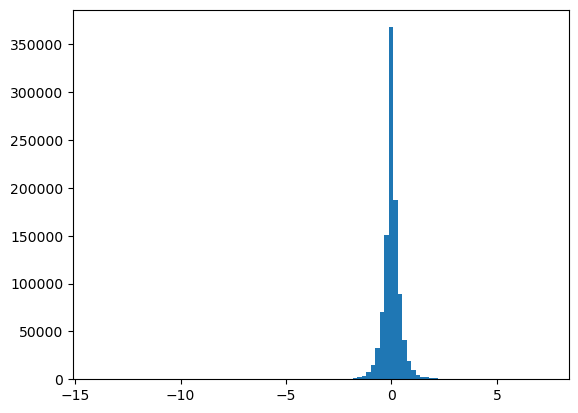

In [32]:
# make a histogram of all the values in the torch tensor E
plt.hist(E.flatten(), 100)

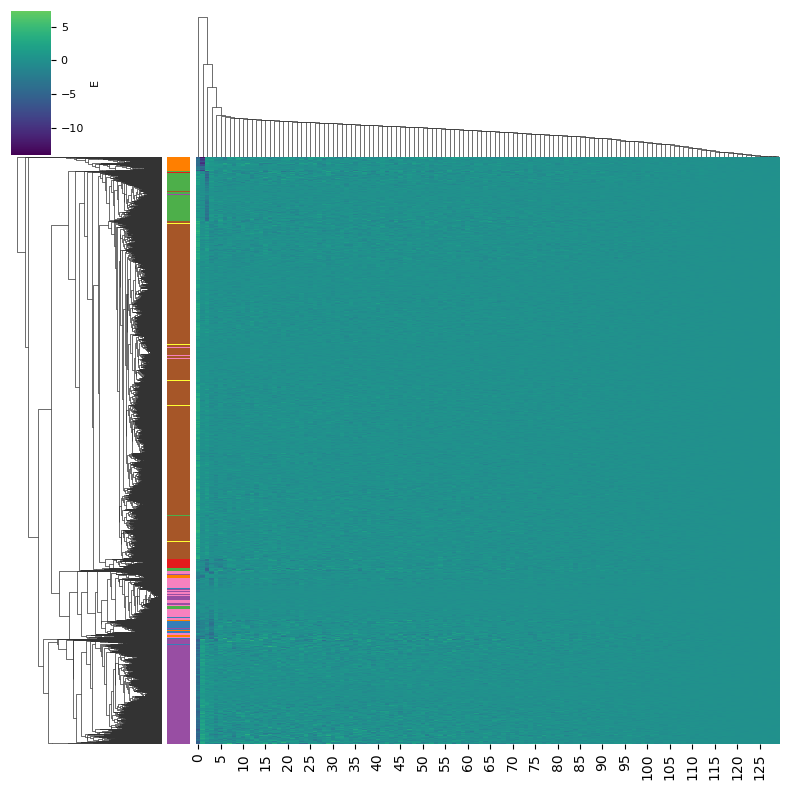

In [33]:
cluster = sns.clustermap(
    data=E,
    method='complete',
    cmap="viridis",
    annot=False,
    fmt=".2f",
    yticklabels=False,
    figsize=(8, 8),
    center=0,
    row_colors=row_colors,  # Apply row colors
    cbar_kws={'label': 'E'} 
    )
cluster.cax.set_ylabel('E', size=8)
# Increase font size for color bar tick labels:
cbar_ax = cluster.cax
for label in cbar_ax.yaxis.get_ticklabels():
    label.set_size(8)

Text(0.5, 0, 'Cell Type')

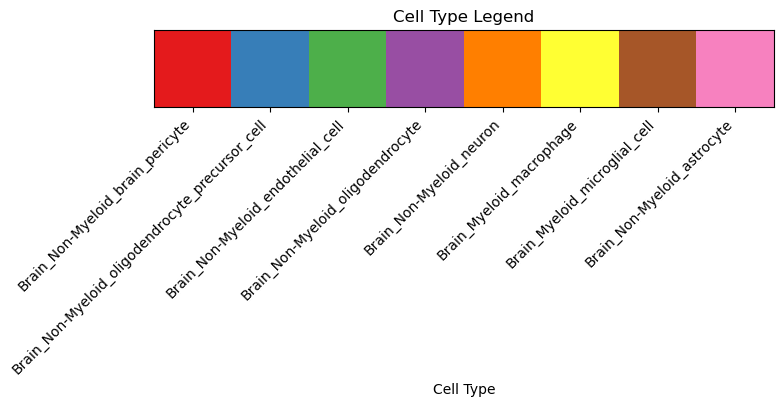

In [34]:
# print cell type color legend seperately
cell_type_colors
# Create a color bar legend
legend = sns.color_palette(palette=color_palette, as_cmap=True)
sns.palplot(color_palette)
plt.title("Cell Type Legend")
# add cell type names to legend
plt.xticks(np.arange(len(unique_cell_types)), unique_cell_types, rotation=45, ha='right')
plt.xlabel("Cell Type")

In [35]:
# let's calculate silhouette score ussing assign_post
silhouette_score(E, cell_types)

0.03139336

In [36]:
# compute Davies-Bouldin Index 
from sklearn.metrics import davies_bouldin_score
davies_bouldin_score(E, cell_types) # closer to zero indicates better partition 

3.5535009146824788